In [1]:
import nilearn
from nilearn.image import resample_img
import nibabel as nib
from templateflow import api
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

from scipy.signal import savgol_filter

In [2]:
subject_idx=4

In [4]:
## get functional data
path_to_data = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/func"
path_to_anat = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/anat"
anat_filename = f"sub-{subject_idx:02d}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
#sub-03_space-MNI152NLin2009cAsym_desc-preproc_T1w
bold_filename = f"sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
mask_filename = f"sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
anat = nib.load(os.path.join(path_to_anat, anat_filename))
bold = nib.load(os.path.join(path_to_data, bold_filename))
mask = nib.load(os.path.join(path_to_data, mask_filename))

In [5]:
## get atlas
path = api.get('MNI152NLin2009cAsym', atlas="Schaefer2018", desc="1000Parcels17Networks", resolution=2, suffix="dseg", extension="nii.gz")
atlas = nib.load(path)
target_affine = atlas.affine
target_shape = np.array(atlas.dataobj).shape

# get the atlas labels
atlas_labels = np.unique(np.array(atlas.dataobj))

In [6]:
resampled_mask = resample_img(mask, target_affine=target_affine, target_shape=target_shape[0:3], interpolation='nearest')
resampled_bold = resample_img(bold, target_affine=target_affine, target_shape=target_shape[0:3])

In [7]:
stim_onsets = np.array([0,60,120,180,240])+300
stim_len = 20
isi = 60

dm = pd.DataFrame(np.zeros(shape=(900,3)), columns=['baseline','fus','recovery'], index=np.arange(900))
dm["baseline"].iloc[0:300] = 1
dm["fus"].iloc[300:600] = 1
dm["recovery"].iloc[600:900] = 1

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_13647/2033162873.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dm["baseline"].iloc[0:300] = 1
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_13647/2033162873.py:7: 

## percent signal change

In [8]:
mu_bsl = np.mean(resampled_bold.get_fdata()[:,:,:,0:300], axis=-1)
mu_fus = np.mean(resampled_bold.get_fdata()[:,:,:,300:600], axis=-1)
mu_rec = np.mean(resampled_bold.get_fdata()[:,:,:,600:900], axis=-1)

sigma_bsl = np.std(resampled_bold.get_fdata()[:,:,:,0:300], axis=-1)
sigma_fus = np.std(resampled_bold.get_fdata()[:,:,:,300:600], axis=-1)
sigma_rec = np.std(resampled_bold.get_fdata()[:,:,:,600:900], axis=-1)

In [9]:
is_outside_brain = resampled_mask.get_fdata() == 0

mu_bsl[is_outside_brain] = np.nan
mu_fus[is_outside_brain] = np.nan
mu_rec[is_outside_brain] = np.nan

sigma_bsl[is_outside_brain] = np.nan
sigma_fus[is_outside_brain] = np.nan
sigma_rec[is_outside_brain] = np.nan

In [10]:
mu_pct_change = (mu_fus-mu_bsl)/mu_bsl
mu_pct_change_img = nib.Nifti1Image(mu_pct_change, affine=target_affine)

mu_pct_change_rec = (mu_rec-mu_bsl)/mu_bsl
mu_pct_change_rec_img = nib.Nifti1Image(mu_pct_change_rec, affine=target_affine)

sigma_pct_change = (sigma_fus-sigma_bsl)/sigma_bsl
sigma_pct_change_img = nib.Nifti1Image(sigma_pct_change, affine=target_affine)

sigma_pct_change_rec = (sigma_rec-sigma_bsl)/sigma_bsl
sigma_pct_change_rec_img = nib.Nifti1Image(sigma_pct_change_rec, affine=target_affine)

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_13647/3310298630.py:7: RuntimeWarning: invalid value encountered in divide
  sigma_pct_change = (sigma_fus-sigma_bsl)/sigma_bsl
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_13647/3310298630.py:10: RuntimeWarning: divide by zero encountered in divide
  sigma_pct_change_rec = (sigma_rec-sigma_bsl)/sigma_bsl
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_13647/3310298630.py:10: RuntimeWarning: invalid value encountered in divide
  sigma_pct_change_rec = (sigma_rec-sigma_bsl)/sigma_bsl


/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:1283: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


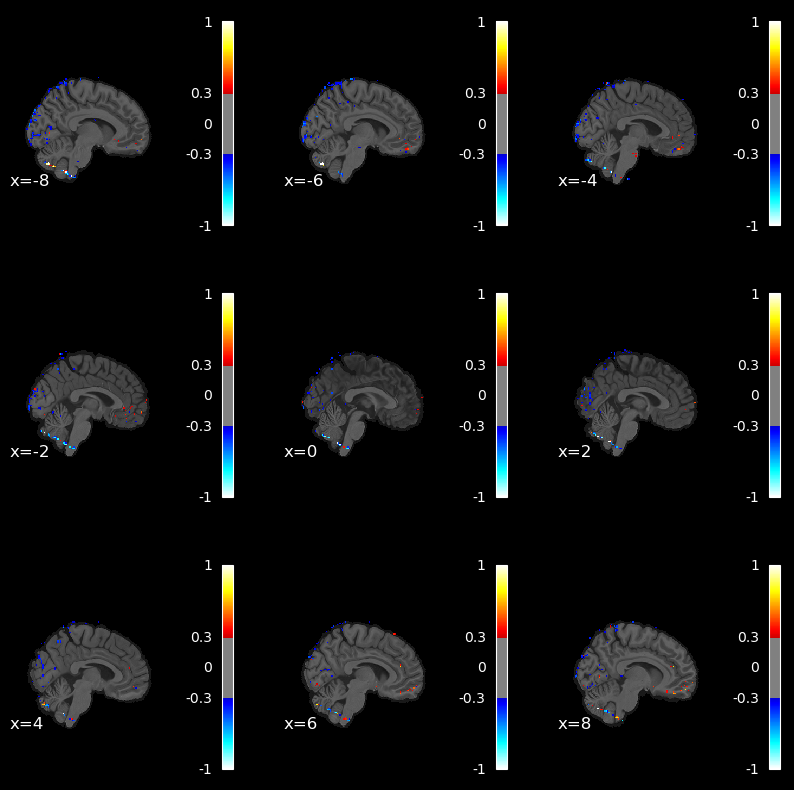

In [11]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(sigma_pct_change_img, bg_img = anat,
                           threshold=0.3, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
plt.savefig(f"sub-{subject_idx:02d}_sigma_pct_change.png", dpi=300, facecolor='grey')

/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:1283: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


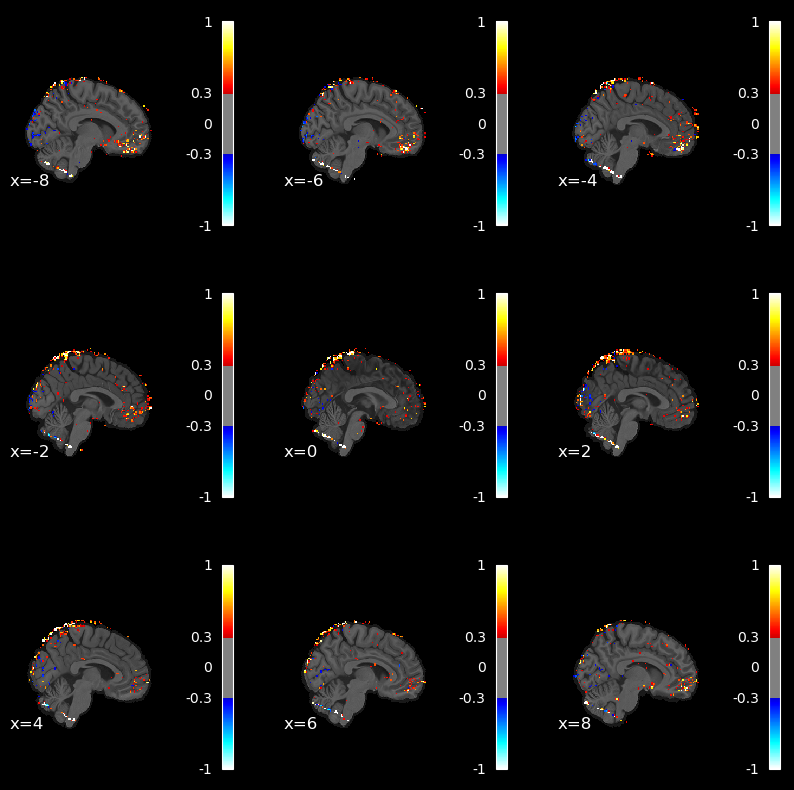

In [12]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(sigma_pct_change_rec_img, bg_img = anat,
                           threshold=0.3, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
plt.savefig(f"sub-{subject_idx:02d}_sigma_pct_change_rec.png", dpi=300, facecolor='grey')

/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:1283: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


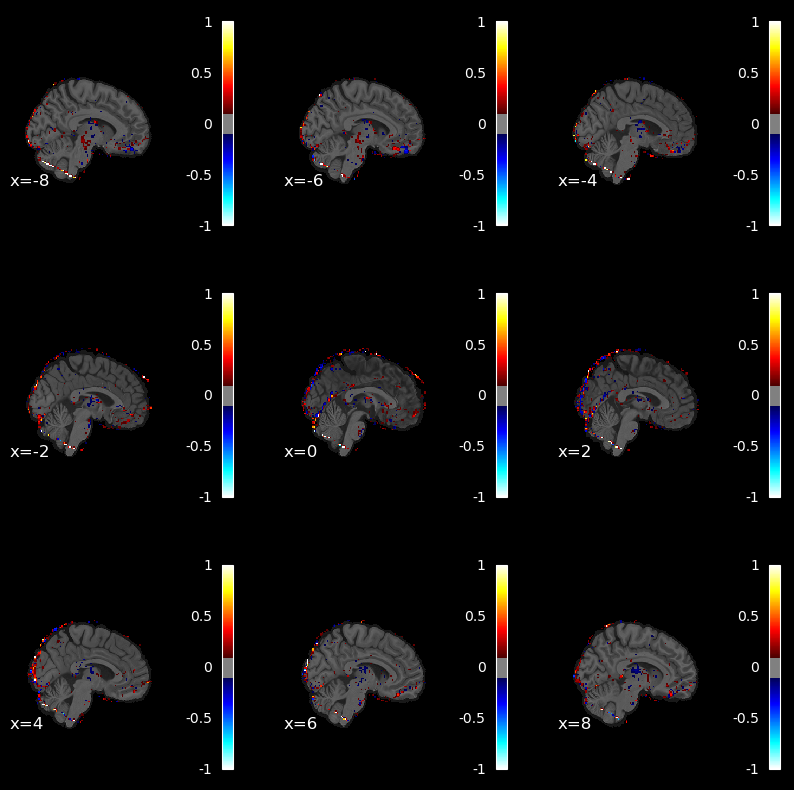

In [13]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(mu_pct_change_rec_img, bg_img = anat,
                           threshold=0.1, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
plt.savefig(f"sub-{subject_idx:02d}_mu_pct_change_rec.png", dpi=300, facecolor='grey')

/Users/jacekdmochowski/miniconda3/envs/tfmetal/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:1283: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


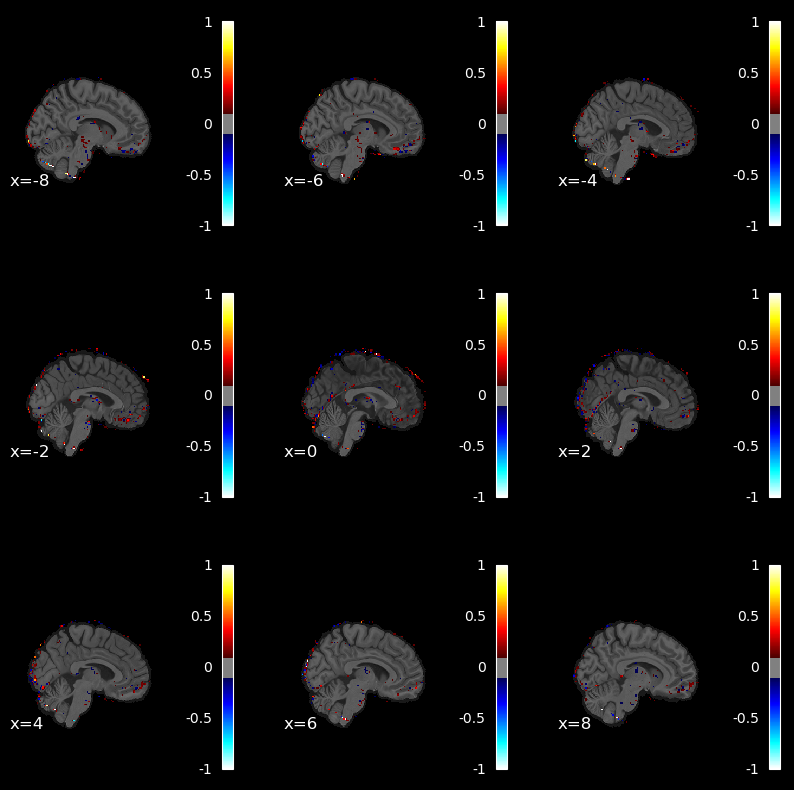

In [14]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(mu_pct_change_img, bg_img = anat,
                           threshold=0.1, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
plt.savefig(f"sub-{subject_idx:02d}_mu_pct_change.png", dpi=300, facecolor='grey')

## ROI time series

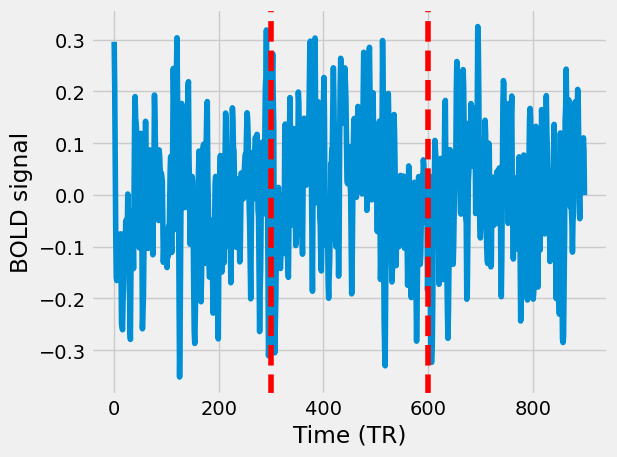

In [15]:
# get the time series of ROI 856
#roi_idx = [332,333]
#roi_idx = np.arange(938,948)
roi_idx = [855,856]

# create an roi mask that contains all indices in roi_idx
roi_mask = np.isin(atlas.get_fdata(), roi_idx)
roi_mask = roi_mask.astype(float)

roi_mask_img = nib.Nifti1Image(roi_mask, affine=target_affine)
roi_ts = nilearn.masking.apply_mask(resampled_bold, roi_mask_img)

## standardize each voxel in roi_ts
roi_ts = (roi_ts - np.mean(roi_ts, axis=0))/np.std(roi_ts, axis=0)

roi_ts_smooth = savgol_filter(roi_ts, window_length=10, polyorder=4, axis=0)

# switch to plot style of the fivethirtyeight
plt.style.use('fivethirtyeight')

plt.plot(np.mean(roi_ts_smooth,axis=1))
plt.axvline(x=300, color='r', linestyle='--')
plt.axvline(x=600, color='r', linestyle='--')
plt.xlabel('Time (TR)')
plt.ylabel('BOLD signal')

plt.tight_layout()
plt.savefig(f"sub-{subject_idx:02d}_roi_ts_RH_ACC.png")

## GLM

In [16]:
## design matrix generation
# column 1: baseline 0-300
stim_onsets = np.array([0,60,120,180,240])+300
stim_len = 20
isi = 60
dm = np.zeros((resampled_bold.shape[3],len(stim_onsets)+2))
# 1st column: baseline, 2nd column: stim onsets, 3rd column: stim offsets, 4th column: constant
# column 1: baseline 0-300
for i, onset in enumerate(stim_onsets):
    print(f"Onset {i}: {onset} samples")
    dm[onset:onset+stim_len,i] = 1

dm[0:300,5] = 1
dm[:,6] = 1

# create a pandas dataframe from dm
dm = pd.DataFrame(dm, columns=['stim1', 'stim2', 'stim3', 'stim4', 'stim5','baseline','constant'])

Onset 0: 300 samples
Onset 1: 360 samples
Onset 2: 420 samples
Onset 3: 480 samples
Onset 4: 540 samples


In [17]:
## set up a GLM analysis
first_level_model = FirstLevelModel(t_r=1.0,
                                    drift_model="cosine", high_pass=0.01,
                                    mask_img=resampled_mask,
                                    standardize=True)
first_level_model.fit(resampled_bold, design_matrices=[dm])

FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x10331e3b0>,
                t_r=1.0)

In [18]:
#
beta = first_level_model.compute_contrast('stim1+stim2+stim3+stim4+stim5-baseline', output_type='z_score')

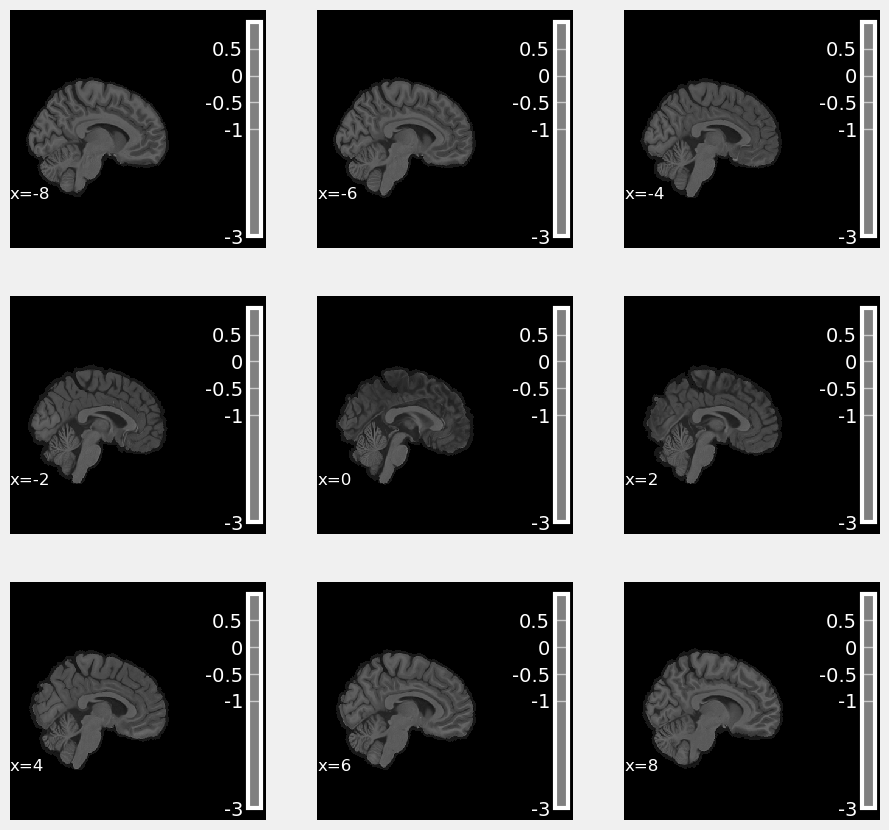

In [20]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(beta, bg_img = anat,
                           threshold=3, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

#fig1.patch.set_facecolor('black')
#plt.savefig(f"sub-{subject_idx:02d}_mu_pct_change.png", dpi=300, facecolor='grey')

## ERP analyis

In [21]:
# epoch resampled_bold starting at each stim onset and with the epoch duration being 60 samples
epoch_duration = 60
#epochs = np.zeros((epoch_duration, len(stim_onsets), resampled_bold.shape[0], resampled_bold.shape[1], resampled_bold.shape[2]))
epochs = np.zeros((resampled_bold.shape[0], resampled_bold.shape[1], resampled_bold.shape[2], epoch_duration, len(stim_onsets) ))
for i, onset in enumerate(stim_onsets):
    epochs[:,:,:,:,i] = resampled_bold.get_fdata()[:,:,:,onset:onset+epoch_duration]

In [22]:
mu_epochs = np.mean(epochs, axis=-1)
mu_epochs_img = nib.Nifti1Image(mu_epochs, affine=target_affine)

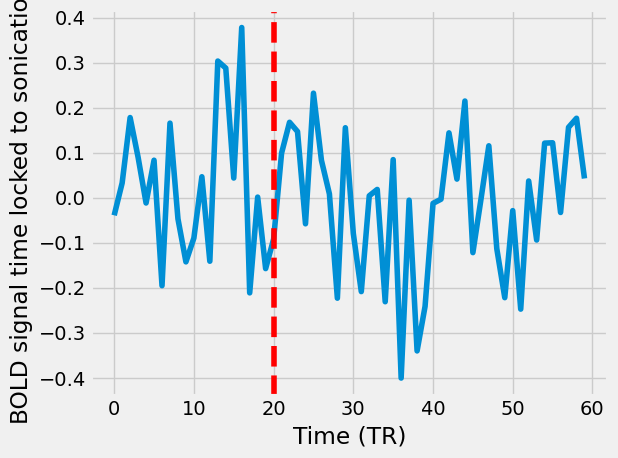

In [24]:
# extract the time series from the ROI 856
roi_idx = [855,856]
#roi_idx = [332,333]

roi_mask_img = nib.Nifti1Image(np.isin(atlas.get_fdata(), roi_idx).astype(float), affine=target_affine)
roi_ts = nilearn.masking.apply_mask(resampled_bold, roi_mask_img)

roi_epoched_ts = nilearn.masking.apply_mask(mu_epochs_img, roi_mask_img)

### standardize each voxel in roi_ts
roi_epoched_ts = (roi_epoched_ts - np.mean(roi_epoched_ts, axis=0))/np.std(roi_epoched_ts, axis=0)

roi_epoched_ts_smooth = savgol_filter(roi_epoched_ts, window_length=5, polyorder=4, axis=0)

plt.plot(np.mean(roi_epoched_ts_smooth, axis=1))
plt.axvline(x=20, color='r', linestyle='--', label='end FUS')
plt.xlabel('Time (TR)')
plt.ylabel('BOLD signal time locked to sonication')

plt.tight_layout()
#plt.savefig(f"sub-{subject_idx:02d}_roi_epoched_ts_LH_ACC.png")

In [86]:
roi_epoched_ts_smooth.shape

(60, 82)

Text(0, 0.5, 'BOLD signal time locked to sonication')

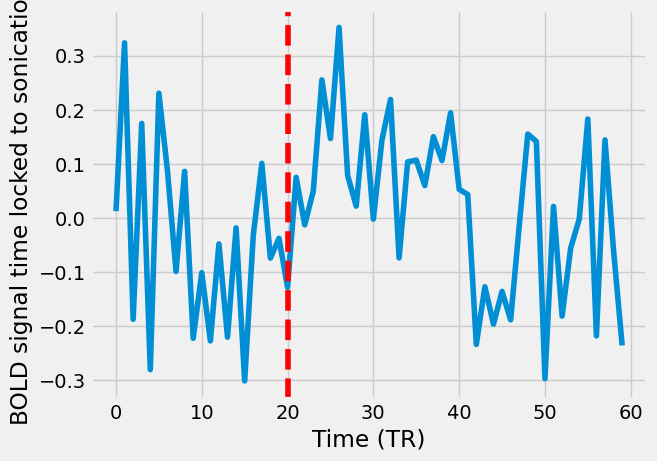